## Answering Business Questions using SQL

In this project, we will answer some business questions for a fictional digital music shop, Chinook, kind of like a mini-iTunes store. We'll be working with a modified version of a database called [Chinook](https://github.com/lerocha/chinook-database).

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.

## Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting New Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and our taski is to select the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name	|Genre|
|---------------|-----|
|Regal|	Hip-Hop|
|Red Tone	|Punk|
|Meteor and the Girls|	Pop|
|Slim Jim Bites |	Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [2]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


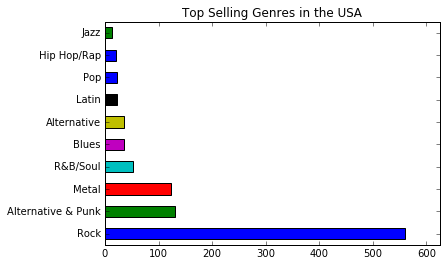

In [11]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
)

plt.ylabel('')
plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. 

Here we are going to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [4]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


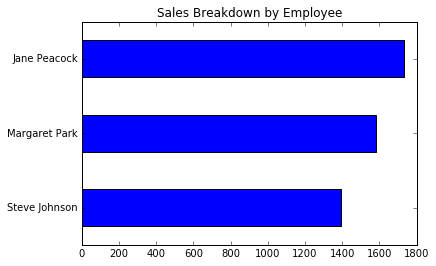

In [12]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
)
plt.ylabel('')
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. 

In particular, we are going to calculate data, for each country, on the:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, we will group these customers as "Other" in our analysis.

In [6]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing Sales by Country

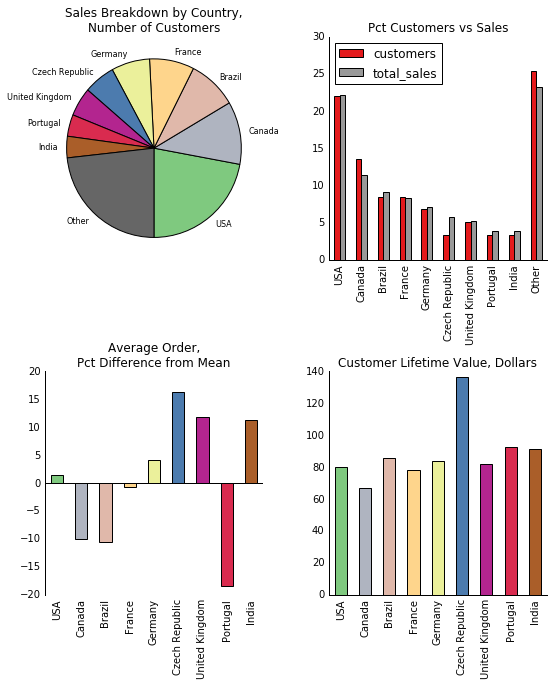

In [17]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low.  Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence.  A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Top Artist in Playlists

Here we are going to find out which artist is used in the most playlists.

In [73]:
top_artist_playlit = '''
WITH artists_by_playlist AS
    (
    SELECT 
        pt.playlist_id,
        ar.name as artist_name,
        ar.artist_id
    FROM track t
    INNER JOIN playlist_track pt on pt.track_id = t.track_id
    INNER JOIN album al on al.album_id = t.album_id
    INNER JOIN artist ar on ar.artist_id = al.artist_id
    GROUP BY 1,2
    ORDER BY 1
    )

SELECT
    artist_name,
    COUNT(artist_id) as frequence_artist
FROM artists_by_playlist
GROUP BY artist_id
ORDER by 2 DESC
LIMIT 1
'''
run_query(top_artist_playlit)

,artist_name,frequence_artist
0,Eugene Ormandy,7


The artist used in the most playlists is Eugene Ormandy, an american artist of classical music.

The fact that a classical artist is the artist most used in playlists leads us to wonder what genre of music are used in most playlists.

## Top Genre in Playlists

In [77]:
top_genre_playlist = '''
WITH genre_by_playlist AS
    (
    SELECT 
        pt.playlist_id,
        g.name as genre_name,
        g.genre_id
    FROM track t
    INNER JOIN playlist_track pt on pt.track_id = t.track_id
    INNER JOIN genre g on g.genre_id = t.genre_id
    GROUP BY 1,3
    ORDER BY pt.playlist_id
    )

SELECT
    genre_name,
    COUNT(genre_id) as frequence_genre
FROM genre_by_playlist
GROUP BY genre_id
ORDER by 2 DESC
LIMIT 3
'''
run_query(top_genre_playlist)

,genre_name,frequence_genre
0,Classical,7
1,Rock,5
2,Soundtrack,5


Out of 18 playlists, 7 playlists contain classical music which makes it the most used genre in playlists.

Based on this observation, we would like to know if the content of the playlists reflect sales popularity in terms of genre of music. 
In other words are the most purchased music genres globally the same as the most used music genre in playlist ?

## Most popular genre : Purchases vs Playlists

In [80]:
genre_purchased = '''
WITH tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
   )

SELECT
    g.name genre,
    count(ts.invoice_line_id) tracks_sold
FROM tracks_sold ts
INNER JOIN track t on t.track_id = ts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(genre_purchased)

,genre,tracks_sold
0,Rock,2635
1,Metal,619
2,Alternative & Punk,492
3,Latin,167
4,R&B/Soul,159
5,Blues,124
6,Jazz,121
7,Alternative,117
8,Easy Listening,74
9,Pop,63


It seems that, globally, Rock is by far the most purchased music genre in our store. This leads us to question the relevance of the content proposed in our playlists. Is it aligned with the type of music that the store mainly sells. 

However, the content of playlists may be related to current musical trends. It would be interesting to find out what kind of music has been most purchased in the last two years (2018 and 2019).

In [99]:
recent_genre_purchased = '''
WITH tracks_sold AS
   (
    SELECT 
        il.* ,
        i.invoice_date as invoice_date,
        strftime('%Y',invoice_date) as year_purchase
    FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE strftime('%Y',invoice_date) = "2019" OR strftime('%Y',invoice_date) = "2018"
    )

SELECT
    g.name genre,
    count(ts.invoice_line_id) tracks_sold
FROM tracks_sold ts
INNER JOIN track t on t.track_id = ts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(recent_genre_purchased)

,genre,tracks_sold
0,Rock,1264
1,Metal,345
2,Alternative & Punk,285
3,Latin,91
4,Blues,70
5,R&B/Soul,58
6,Easy Listening,49
7,Alternative,48
8,Jazz,43
9,Electronica/Dance,42


It seems that the popularity of the music genres of the last two years is pretty much the same as the historical popularity of music genre in our store. 
Perhaps it would be wise to review the content of the playlists and to adapt it to the sales trends. 